In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import collections
from datetime import datetime

df = pd.read_csv("dataset/complaint_data.csv")
df_col_desc = pd.read_csv("dataset/column_desc.csv")

# Data cleansing - removing null columns and data points

dropcols = ["Lat_Lon","X_COORD_CD","Y_COORD_CD","CMPLNT_NUM"] # Redundant columns
for i in df.columns:
    if float(df[i].isnull().sum())/len(df)*100 > 20: # if more than 10% data is empty, clip the column
        dropcols.append(i)
df = df.drop(dropcols, axis=1)
df = df[~df.isnull().any(axis=1)]

# Parsing the DateTime column 

df["RPT_DT"] = df["RPT_DT"].apply(lambda x: datetime.strptime(x, '%m/%d/%y')
                                  .strftime('%Y-%m-%d')).astype('datetime64[ns]')
df["CMPLNT_FR_DT"] = df["CMPLNT_FR_DT"].apply(lambda x: datetime.strptime(x, '%m/%d/%y')
                                              .strftime('%Y-%m-%d')).astype('datetime64[ns]')
df["CMPLNT_TO_DT"] = df["CMPLNT_TO_DT"].apply(lambda x: datetime.strptime(x, '%m/%d/%y')
                                              .strftime('%Y-%m-%d')).astype('datetime64[ns]')

df["RPT_DT"] = pd.to_datetime(df["RPT_DT"])
df["CMPLNT_FR_DT"] = pd.to_datetime(df["CMPLNT_FR_DT"])
df["CMPLNT_TO_DT"] = pd.to_datetime(df["CMPLNT_TO_DT"])

df["FR_TM_CAT"] = df["CMPLNT_FR_TM"].apply(lambda x: int(x.strip().split(':')[0])//6)
df["FR_TM_CAT"] = df["CMPLNT_TO_TM"].apply(lambda x: int(x.strip().split(':')[0])//6)

# Removing outliers

df = df[~(df['CMPLNT_TO_DT'] >= '2017-01-01')]

In [2]:
# Compiling list of Offenses, their categories and key codes

offense_code = {}
offlist = df["OFNS_DESC"].unique()
for each in offlist:
    key = df[df["OFNS_DESC"]==each]["KY_CD"].unique()[0]
    offense_code[key] = each

print "Offense Codes and Description " + str(len(offense_code))
print ""
offense_code = collections.OrderedDict(sorted(offense_code.items()))
for k,v in offense_code.items():
    print k,v
    
# Repeating the same for Police Codes and Descriptions

pd_code = {}
pdlist = df["PD_DESC"].unique()
for each in pdlist:
    key = df[df["PD_DESC"]==each]["PD_CD"].unique()[0]
    pd_code[key] = each

print ""
print "Police Department Codes and Descriptions " + str(len(pd_code))
pd_code = collections.OrderedDict(sorted(pd_code.items()))
for k,v in pd_code.items():
    print k,v

# INFERENCES

# Using only KY_CD, PD_CD for analysis

#df = df.drop(['PD_DESC','OFNS_DESC'], axis=1)

Offense Codes and Description 54

102 HOMICIDE-NEGLIGENT-VEHICLE
103 HOMICIDE-NEGLIGENT,UNCLASSIFIE
105 ROBBERY
106 FELONY ASSAULT
107 BURGLARY
109 GRAND LARCENY
110 GRAND LARCENY OF MOTOR VEHICLE
111 POSSESSION OF STOLEN PROPERTY
112 THEFT-FRAUD
113 FORGERY
114 ARSON
118 DANGEROUS WEAPONS
119 INTOXICATED/IMPAIRED DRIVING
120 ENDAN WELFARE INCOMP
124 KIDNAPPING
125 NYS LAWS-UNCLASSIFIED FELONY
126 MISCELLANEOUS PENAL LAW
230 JOSTLING
231 BURGLAR'S TOOLS
233 SEX CRIMES
235 DANGEROUS DRUGS
237 ESCAPE 3
238 FRAUDULENT ACCOSTING
340 FRAUDS
341 PETIT LARCENY
342 PETIT LARCENY OF MOTOR VEHICLE
343 THEFT OF SERVICES
344 ASSAULT 3 & RELATED OFFENSES
345 OFFENSES RELATED TO CHILDREN
346 ALCOHOLIC BEVERAGE CONTROL LAW
347 INTOXICATED & IMPAIRED DRIVING
348 VEHICLE AND TRAFFIC LAWS
349 DISRUPTION OF A RELIGIOUS SERV
350 GAMBLING
351 CRIMINAL MISCHIEF & RELATED OF
352 CRIMINAL TRESPASS
353 UNAUTHORIZED USE OF A VEHICLE
354 ANTICIPATORY OFFENSES
355 OFFENSES AGAINST THE PERSON
356 PROSTITUTION & RE

In [3]:
# NOTES

# CRM_ATPT_CPTD_CD - Generate Category variable (Successful, Failed, Attempted)
# Types of Crime across Zipcodes - Start with LAW_CAT_CD
# Precinct involved - look for patterns across this
# Categorical variables include - CRM_ATPT_CPTD_CD, KY_CD, PD_CD, LAW_CAT_CD, ADDR_PCT_CD, 
#                                 BORO_NM, PREM_TYP_DESC, ZIPCODE
# Numerical variables - Latitude, Longitude
# TRY - KMODES clustering for mixed data
# Check diff in dates of crime committed and reported
# Drop columns PD_CD, PD_DESC, OFNS_DESC
# Duration of crimes - 'CMPLNT_FR_TM','CMPLNT_TO_TM'

In [4]:
# MACHINE LEARNING - GENERATING CATEGORY VARIABLES

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df['CRM_ATPT_CPTD_CD'])
df['CRM_CAT'] = le.transform(df['CRM_ATPT_CPTD_CD'])

le = preprocessing.LabelEncoder()
le.fit(df['LAW_CAT_CD'])
df['LAW_CAT'] = le.transform(df['LAW_CAT_CD'])

le = preprocessing.LabelEncoder()
le.fit(df['JURIS_DESC'])
df['JURIS_CAT'] = le.transform(df['JURIS_DESC'])

le = preprocessing.LabelEncoder()
le.fit(df['BORO_NM'])
df['BORO_CAT'] = le.transform(df['BORO_NM'])

le = preprocessing.LabelEncoder()
le.fit(df['PREM_TYP_DESC'])
df['PREM_CAT'] = le.transform(df['PREM_TYP_DESC'])

df['DATE_CAT'] = df['CMPLNT_FR_DT'].map(lambda x: x.month)
df = df.reset_index(drop=True)

In [10]:
# K-Means Clustering Algorithm
from sklearn.neighbors import NearestNeighbors
from kmodes.kprototypes import KPrototypes

# KMeans Algorithm

from sklearn.cluster import KMeans
def clustering(train, usecols, n):
    #kmeans = KMeans(n_clusters=n, random_state=0,).fit(train)
    kproto = KPrototypes(n_clusters=n, init='Cao', verbose=2)
    kproto.fit_predict(train, categorical=usecols)
    return kproto.cluster_centroids_, kproto.labels_

cols = ["FR_TM_CAT","DATE_CAT","KY_CD","CRM_CAT","LAW_CAT","BORO_CAT","ADDR_PCT_CD",
        "PREM_CAT","Latitude","Longitude"]
cat = [0,1,2,3,4,5,6,7] # as first n columns are categorical
num_clusters = 2
centers2, labels22 = clustering(df[cols].as_matrix(),cat,num_clusters)
print centers2

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 39139, ncost: 67884305.6645
Run: 1, iteration: 2/100, moves: 902, ncost: 67884305.6115
Run: 1, iteration: 3/100, moves: 103, ncost: 67884305.6109
Run: 1, iteration: 4/100, moves: 20, ncost: 67884305.6109
Run: 1, iteration: 5/100, moves: 1, ncost: 67884305.6109
Run: 1, iteration: 6/100, moves: 0, ncost: 67884305.6109
[array([[ 40.7108116 , -73.92789733],
       [ 40.76538523, -73.92200697]]), array([[   2.,   10.,  341.,    1.,    1.,    1.,   75.,   58.],
       [   3.,    9.,  109.,    1.,    0.,    2.,   14.,   49.]])]


In [5]:
# K-Means Clustering Algorithm
from sklearn.neighbors import NearestNeighbors
from kmodes.kprototypes import KPrototypes

# KMeans Algorithm

from sklearn.cluster import KMeans
def clustering(train, usecols, n):
    #kmeans = KMeans(n_clusters=n, random_state=0,).fit(train)
    kproto = KPrototypes(n_clusters=n, init='Cao', verbose=2)
    kproto.fit_predict(train, categorical=usecols)
    return kproto.cluster_centroids_, kproto.labels_

cols = ["FR_TM_CAT","DATE_CAT","KY_CD","CRM_CAT","LAW_CAT","BORO_CAT","ADDR_PCT_CD",
        "PREM_CAT","Latitude","Longitude"]
cat = [0,1,2,3,4,5,6,7] # as first n columns are categorical
num_clusters = 3

centers, labels = clustering(df[cols].as_matrix(),cat,num_clusters)
print centers

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 61537, ncost: 64529186.4909
Run: 1, iteration: 2/100, moves: 3148, ncost: 64529186.2363
Run: 1, iteration: 3/100, moves: 243, ncost: 64529186.2314
Run: 1, iteration: 4/100, moves: 44, ncost: 64529186.2311
Run: 1, iteration: 5/100, moves: 2, ncost: 64529186.2311
Run: 1, iteration: 6/100, moves: 0, ncost: 64529186.2311
[array([[ 40.70255807, -73.94656836],
       [ 40.76374052, -73.93925212],
       [ 40.74696025, -73.87418128]]), array([[   2.,   10.,  341.,    1.,    1.,    1.,   75.,   58.],
       [   3.,    9.,  109.,    1.,    0.,    2.,   14.,   49.],
       [   1.,   11.,  344.,    1.,    1.,    3.,  114.,   49.]])]


In [11]:
# K-Means Clustering Algorithm
from sklearn.neighbors import NearestNeighbors
from kmodes.kprototypes import KPrototypes

# KMeans Algorithm

from sklearn.cluster import KMeans
def clustering(train, usecols, n):
    #kmeans = KMeans(n_clusters=n, random_state=0,).fit(train)
    kproto = KPrototypes(n_clusters=n, init='Cao', verbose=2)
    kproto.fit_predict(train, categorical=usecols)
    return kproto.cluster_centroids_, kproto.labels_

cols = ["FR_TM_CAT","DATE_CAT","KY_CD","CRM_CAT","LAW_CAT","BORO_CAT","ADDR_PCT_CD",
        "PREM_CAT","Latitude","Longitude"]
cat = [0,1,2,3,4,5,6,7] # as first n columns are categorical
num_clusters = 4
centers4, labels4 = clustering(df[cols].as_matrix(),cat,num_clusters)
print centers4

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 104497, ncost: 62085639.8525
Run: 1, iteration: 2/100, moves: 4652, ncost: 62085639.2356
Run: 1, iteration: 3/100, moves: 127, ncost: 62085639.2349
Run: 1, iteration: 4/100, moves: 1, ncost: 62085639.2349
Run: 1, iteration: 5/100, moves: 0, ncost: 62085639.2349
[array([[ 40.68276435, -73.95243167],
       [ 40.74250527, -73.95166624],
       [ 40.72073885, -73.87293915],
       [ 40.81208904, -73.90180966]]), array([[   2.,   10.,  341.,    1.,    1.,    1.,   75.,   58.],
       [   3.,    9.,  109.,    1.,    0.,    2.,   14.,   49.],
       [   1.,   11.,  344.,    1.,    1.,    3.,  114.,   49.],
       [   3.,   12.,  351.,    1.,    1.,    0.,   47.,   58.]])]


In [12]:
# K-Means Clustering Algorithm
from sklearn.neighbors import NearestNeighbors
from kmodes.kprototypes import KPrototypes

# KMeans Algorithm

from sklearn.cluster import KMeans
def clustering(train, usecols, n):
    #kmeans = KMeans(n_clusters=n, random_state=0,).fit(train)
    kproto = KPrototypes(n_clusters=n, init='Cao', verbose=2)
    kproto.fit_predict(train, categorical=usecols)
    return kproto.cluster_centroids_, kproto.labels_

cols = ["FR_TM_CAT","DATE_CAT","KY_CD","CRM_CAT","LAW_CAT","BORO_CAT","ADDR_PCT_CD",
        "PREM_CAT","Latitude","Longitude"]
cat = [0,1,2,3,4,5,6,7] # as first n columns are categorical
num_clusters = 5
centers5, labels5 = clustering(df[cols].as_matrix(),cat,num_clusters)
print centers5

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 99830, ncost: 60408716.7807
Run: 1, iteration: 2/100, moves: 21603, ncost: 60408695.5541
Run: 1, iteration: 3/100, moves: 5314, ncost: 60408694.205
Run: 1, iteration: 4/100, moves: 1454, ncost: 60408694.0856
Run: 1, iteration: 5/100, moves: 462, ncost: 60408694.0743
Run: 1, iteration: 6/100, moves: 181, ncost: 60408694.0729
Run: 1, iteration: 7/100, moves: 73, ncost: 60408694.0724
Run: 1, iteration: 8/100, moves: 31, ncost: 60408694.0723
Run: 1, iteration: 9/100, moves: 21, ncost: 60408694.0722
Run: 1, iteration: 10/100, moves: 4, ncost: 60408694.0722
[array([[ 40.69062131, -73.95746084],
       [ 40.75598473, -73.95020936],
       [ 40.72407031, -73.87162994],
       [ 40.81318536, -73.90228816],
       [ 40.67914279, -73.92913548]]), array([[   2.,   10.,  341.,    1.,    1.,    1.,   75.,   58.],


In [6]:
df['labels'] = labels
print df['labels'].value_counts()

# 1. Plot number of crimes vs clusters # not useful
# 2. Plot lat-long for every clusters and compare
# 3. Plot number of crimes foiled (%) vs clusters
# 4. Plot category of crimes for every clusters
# 5. Plot category of premises for every clusters
# 6. Check distribution of boroughs across clusters

0    227241
1    149692
2    132397
Name: labels, dtype: int64


In [8]:
df['labels'].value_counts()

0    227241
1    149692
2    132397
Name: labels, dtype: int64

In [9]:
cluster0 = df[df['labels']==0]
cluster1 = df[df['labels']==1]
cluster2 = df[df['labels']==2]

In [97]:
# 2. Plot lat-long/ZIPCODE for every clusters and compare

plotme = df[["ZIPCODE","labels"]]

[ 10451.  11222.  10011.  11236.  10304.  10305.  10029.  11214.  10005.
  10468.  11233.  10459.  10461.  10023.  11228.  11225.  11201.  11207.
  11210.  11226.  10035.  11206.  10019.  11208.  11213.  11211.  11361.
  11694.  11216.  10310.  11212.  10455.  10013.  11235.  11232.  11234.
  10027.  11373.  11378.  11209.  10469.  11217.  10025.  11203.  11362.
  10467.  10302.  11368.  10457.  10036.  10307.  11205.  10456.  11224.
  10128.  11691.  10303.  11416.  11435.  11372.  11204.  10458.  11229.
  10312.  11101.  10475.  11219.  10453.  11223.  11215.  11418.  11218.
  10002.  11237.  10012.  10038.  11385.  10301.  11230.  10463.  10033.
  11692.  10314.  10028.  10460.  10003.  10022.  11231.  10007.  11220.
  11433.  10010.  10017.  11249.  10009.  10001.  10462.  10465.  11354.
  10309.  11375.  11422.  11370.  11238.  10466.  11429.  10032.  10306.
  11421.  10014.  10026.  11355.  10473.  11221.  11434.  10030.  10464.
  10452.  11106.  11697.  10034.  10039.  11432.  1

COMPLETED 0.985081917436 0.973619164685 0.988458952997


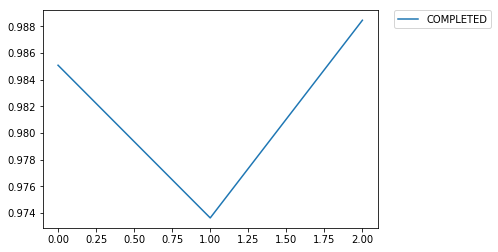

ATTEMPTED 0.0149180825643 0.0263808353152 0.0115410470026


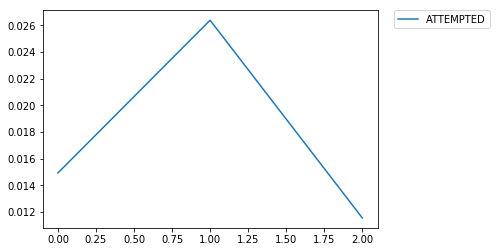

In [79]:
# 3. Plot number of crimes foiled (%) vs clusters

for i in ["COMPLETED","ATTEMPTED"]:
    val0 = float(len(cluster0[cluster0['CRM_ATPT_CPTD_CD']==i]))/len(cluster0)
    val1 = float(len(cluster1[cluster1['CRM_ATPT_CPTD_CD']==i]))/len(cluster1)
    val2 = float(len(cluster2[cluster2['CRM_ATPT_CPTD_CD']==i]))/len(cluster2)
    print i + " " + str(val0), str(val1), str(val2)
    plt.plot([0,1,2],[val0,val1,val2],label=i)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

FELONY 0.188126262426 0.662754188601 0.165849679373
MISDEMEANOR 0.693167166136 0.19190738316 0.688195351858
VIOLATION 0.118706571437 0.145338428239 0.145954968768


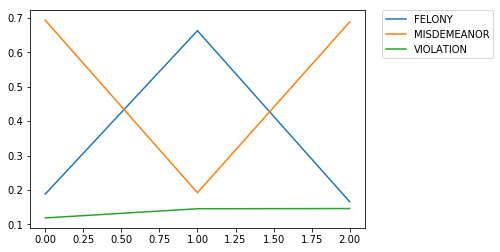

In [76]:
# 4. Plot category of crimes for every clusters

for i in ["FELONY","MISDEMEANOR","VIOLATION"]:
    val0 = float(len(cluster0[cluster0['LAW_CAT_CD']==i]))/len(cluster0)
    val1 = float(len(cluster1[cluster1['LAW_CAT_CD']==i]))/len(cluster1)
    val2 = float(len(cluster2[cluster2['LAW_CAT_CD']==i]))/len(cluster2)
    print i + " " + str(val0), str(val1), str(val2)
    plt.plot([0,1,2],[val0,val1,val2],label=i)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [93]:
# 5. Plot category of premises for every clusters

for i in ([cluster0,cluster1,cluster2]):
    print (i["PREM_TYP_DESC"].value_counts()/len(i))[:10]

Index([u'STREET', u'RESIDENCE - APT. HOUSE', u'RESIDENCE-HOUSE',
       u'RESIDENCE - PUBLIC HOUSING', u'CHAIN STORE', u'DEPARTMENT STORE',
       u'OTHER', u'COMMERCIAL BUILDING', u'GROCERY/BODEGA',
       u'TRANSIT - NYC SUBWAY'],
      dtype='object')
Index([u'RESIDENCE - APT. HOUSE', u'STREET', u'RESIDENCE - PUBLIC HOUSING',
       u'RESIDENCE-HOUSE', u'TRANSIT - NYC SUBWAY', u'COMMERCIAL BUILDING',
       u'OTHER', u'CHAIN STORE', u'RESTAURANT/DINER', u'BAR/NIGHT CLUB'],
      dtype='object')
Index([u'RESIDENCE - APT. HOUSE', u'STREET', u'RESIDENCE-HOUSE',
       u'RESIDENCE - PUBLIC HOUSING', u'OTHER', u'COMMERCIAL BUILDING',
       u'TRANSIT - NYC SUBWAY', u'GROCERY/BODEGA', u'CHAIN STORE',
       u'BAR/NIGHT CLUB'],
      dtype='object')


In [94]:
# 6. Check distribution of boroughs across clusters
for i in ([cluster0,cluster1,cluster2]):
    print (i["BORO_NM"].value_counts()/len(i))

BROOKLYN         0.558376
MANHATTAN        0.162629
BRONX            0.142840
QUEENS           0.074326
STATEN ISLAND    0.061829
Name: BORO_NM, dtype: float64
MANHATTAN        0.483459
BRONX            0.236245
BROOKLYN         0.137275
QUEENS           0.107294
STATEN ISLAND    0.035727
Name: BORO_NM, dtype: float64
QUEENS           0.557052
BRONX            0.254198
MANHATTAN        0.084828
BROOKLYN         0.076444
STATEN ISLAND    0.027478
Name: BORO_NM, dtype: float64


Percentage values for each category of crime across Categories - 


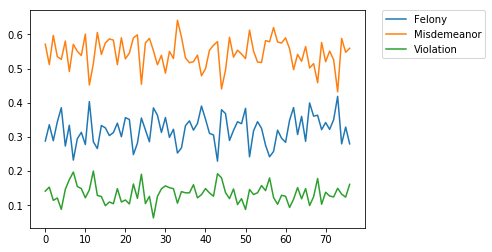

Normalized values - 


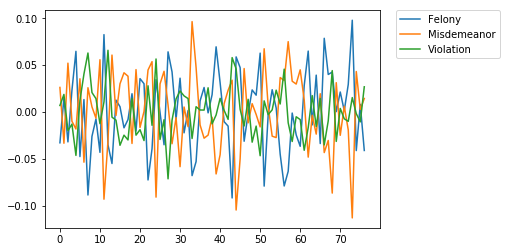

In [68]:
# NOTE 1: THIS IS THROUGH THE WHOLE DATASET, PLOTTING CRIMES AND 
# CATEGORIES OF CRIME - FELONY/MISDEMEANOR/VIOLATION ACROSS PRECINCT NUMBERS

precincts = []
l1 = []
for i in (df["ADDR_PCT_CD"].unique()):
    tot = len(df[df["ADDR_PCT_CD"]==i])
    val = float(len(df[(df["ADDR_PCT_CD"]==i) & (df["LAW_CAT_CD"]=="FELONY")]))
    l1.append(val/tot)
    precincts.append(i)

l2 = []
for i in (df["ADDR_PCT_CD"].unique()):
    tot = len(df[df["ADDR_PCT_CD"]==i])
    val = float(len(df[(df["ADDR_PCT_CD"]==i) & (df["LAW_CAT_CD"]=="MISDEMEANOR")]))
    l2.append(val/tot)

l3 = []
for i in (df["ADDR_PCT_CD"].unique()):
    tot = len(df[df["ADDR_PCT_CD"]==i])
    val = float(len(df[(df["ADDR_PCT_CD"]==i) & (df["LAW_CAT_CD"]=="VIOLATION")]))
    l3.append(val/tot)

l1 = np.array(l1)
l2 = np.array(l2)
l3 = np.array(l3)
print ("Percentage values for each category of crime across Categories - ")
plt.plot(np.arange(len(l1)),l1, label="Felony")
plt.plot(np.arange(len(l2)),l2, label="Misdemeanor")
plt.plot(np.arange(len(l3)),l3, label="Violation")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# The ones that stand out from this - 